# Chapter 4 Exercises

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Simulate an MA(2) Process and Make Forecasts

#### 1. Simulate a Stationary MA(2) Process
To simulate a stationary MA(2) process, use the `ArmaProcess` function from the `statsmodels` library. The process is defined as:

$$
y_t = 0.9\theta_{t-1} + 0.3\theta_{t-2}
$$

For this exercise, generate 1,000 samples.

```python
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define the MA(2) process parameters
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

# Generate the MA(2) process sample
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


In [4]:
np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)

#### 2. Plot your simulated moving average.

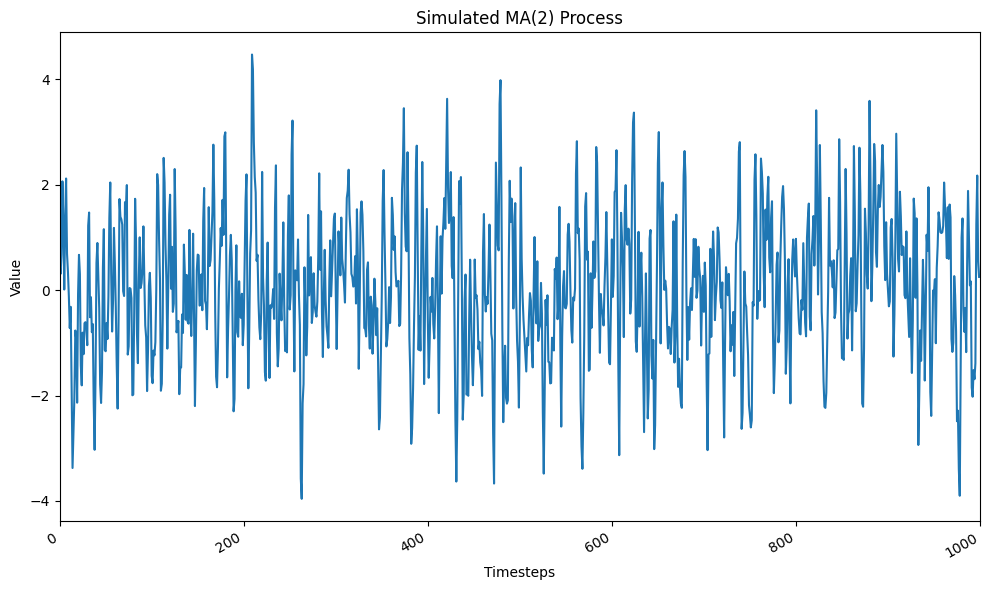

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(MA2_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated MA(2) Process')

ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

#### 3. Run the ADF test, and check if the process is stationary.

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(MA2_process)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -14.00544430919449
p-value: 3.795601616713556e-26

p-value < alpha; Ha: Stationary


#### 4. Plot the ACF, and see if there are significant coefficients after lag 2.

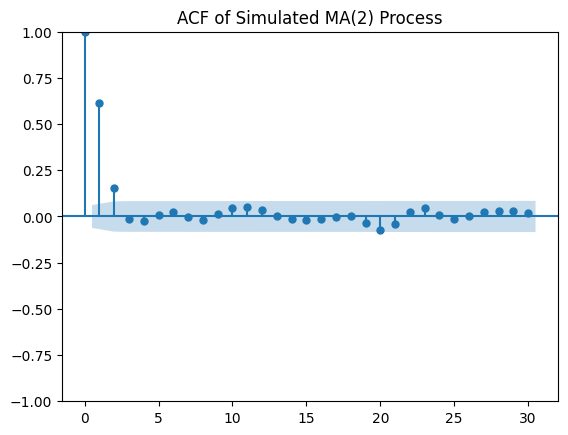

In [10]:
# Plot Auto Correlation Function
plot_acf(MA2_process, lags=30);

plt.title('ACF of Simulated MA(2) Process')

plt.show()

#### 5. Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set, and assign the rest to the test set.

In [12]:
df = pd.DataFrame({'value': MA2_process})

train = df[:800]  # First 800 timesteps
test = df[800:]   # Last 200 timesteps

#### 6. Make forecasts over the test set. Use the mean, last value, and an MA(2) model. Make sure you repeatedly forecast 2 timesteps at a time using the recursive_forecast function we defined.

In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [15]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_MA2'] = pred_MA2

test.head()

,value,pred_mean,pred_last_value,pred_MA2
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


#### 7. Plot your forecasts.

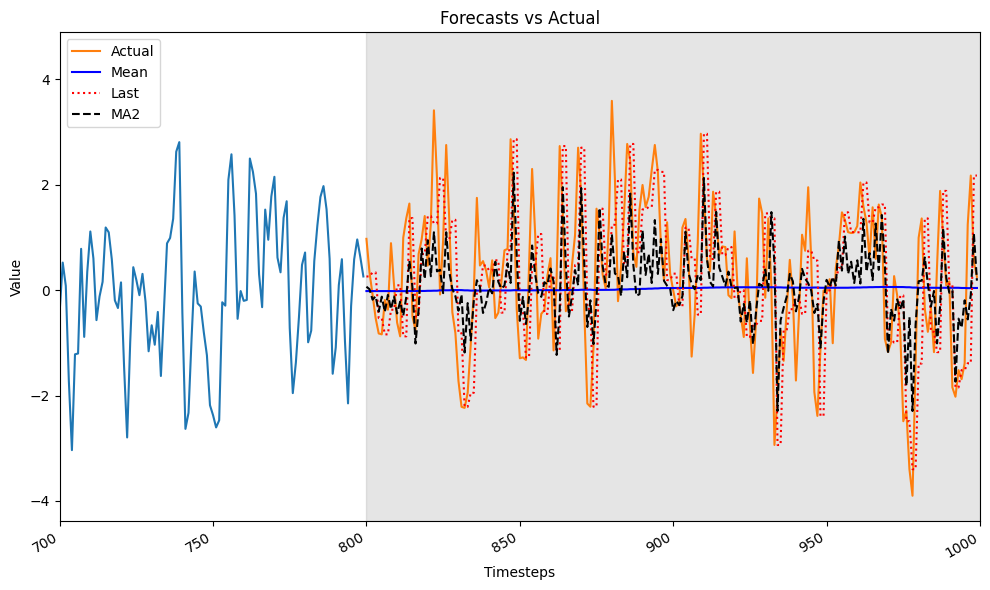

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train)
ax.plot(test['value'], label='Actual')
ax.plot(test['pred_mean'], 'b-', label='Mean')
ax.plot(test['pred_last_value'], 'r:', label='Last')
ax.plot(test['pred_MA2'], 'k--', label='MA2')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Forecasts vs Actual')

ax.legend(loc='best')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

plt.xlim(700, 1000)
fig.autofmt_xdate()
plt.tight_layout()

#### 8. Measure the MSE, and identify your champion model.

In [19]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE for each forecast
mse_mean = mean_squared_error(test['value'], test['pred_mean'])
mse_last = mean_squared_error(test['value'], test['pred_last_value'])
mse_MA = mean_squared_error(test['value'], test['pred_MA2'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean:.2f}')
print(f'MSE (Last Value Forecast): {mse_last:.2f}')
print(f'     MSE (MA(2) Forecast): {mse_MA:.2f}')

      MSE (Mean Forecast): 1.86
MSE (Last Value Forecast): 1.99
     MSE (MA(2) Forecast): 1.23


#### 9. Plot your MSEs in a bar plot

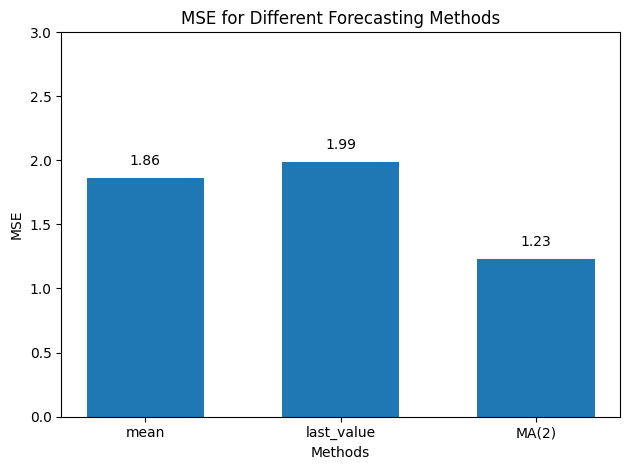

In [21]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

### Exercise 2

#### Simulate a third-order moving average process. 

The equation for the MA(3) process can be written as:

$$
y_t = 0.9 * \theta_{t-1} + 0.3 * \theta_{t-2}  + 0.2 * \theta_{t-3}
$$

Where:
- $ y_t $ is the value of the series at time $ t $,
- $ \theta_{t-1}, \theta_{t-2}, \theta_{t-3} $ are the white noise error terms at lag 1, 2, and 3, respectively,
- The coefficients $ 0.9, 0.3, 0.2 $ represent the weights for the error terms at lags 1, 2, and 3, respectively.


In [24]:
np.random.seed(42)

ma3 = np.array([1, 0.9, 0.3, 0.2])
ar3 = np.array([1, 0, 0, 0])

MA3_process = ArmaProcess(ar3, ma3).generate_sample(nsample=10000)

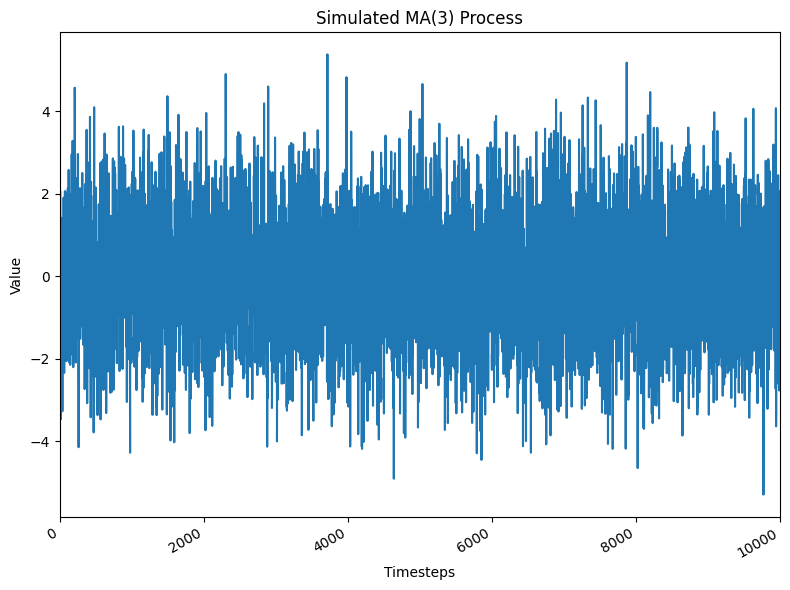

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(MA3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Simulated MA(3) Process')

ax.set_xlim(0, 10000) 

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result3 = adfuller(MA3_process)

# Display ADF test result
print(f"ADF Statistic: {adf_result3[0]}")
print(f"p-value: {adf_result3[1]}")
print()

if adf_result3[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -22.87193326108071
p-value: 0.0

p-value < alpha; Ha: Stationary


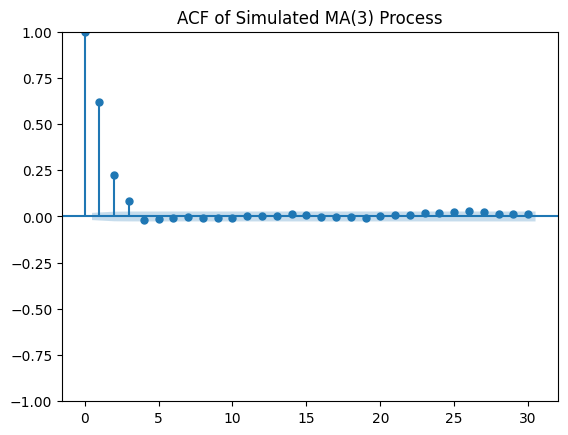

In [27]:
# Plot Auto Correlation Function
plot_acf(MA3_process, lags=30);

plt.title('ACF of Simulated MA(3) Process')

plt.show()

In [28]:
MA3_df = pd.DataFrame({'value': MA3_process})

MA3_train = MA3_df[:-200]  # All until the 200 timesteps
MA3_test = MA3_df[-200:]   # The last 200 timesteps

print(len(MA3_test))

200


In [29]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [30]:
TRAIN_LEN = len(MA3_train)
HORIZON = len(MA3_test)
WINDOW = 3

pred_mean = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA3 = rolling_forecast(MA3_df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

# The rolling forecast generated 201 predictions, but we need only the first
# 200 predictions to match the length of the test set

MA3_test.loc[:, 'pred_mean'] = pred_mean[:200]
MA3_test.loc[:, 'pred_last_value'] = pred_last_value[:200]
MA3_test.loc[:, 'pred_MA3'] = pred_MA3[:200] 

MA3_test.head()

,value,pred_mean,pred_last_value,pred_MA3
9800,-0.090451,-0.004809,-1.184449,-0.997254
9801,0.965698,-0.004809,-1.184449,-0.344161
9802,2.802072,-0.004809,-1.184449,-0.226325
9803,1.397224,-0.004433,2.802072,2.378104
9804,0.700887,-0.004433,2.802072,0.733305


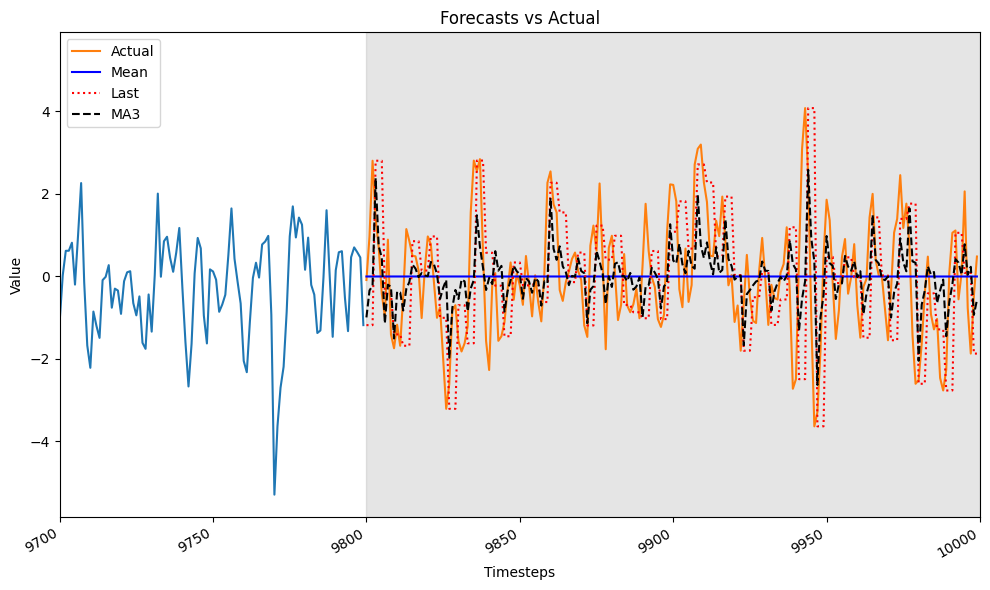

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(MA3_train)
ax.plot(MA3_test['value'], label='Actual')
ax.plot(MA3_test['pred_mean'], 'b-', label='Mean')
ax.plot(MA3_test['pred_last_value'], 'r:', label='Last')
ax.plot(MA3_test['pred_MA3'], 'k--', label='MA3')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.set_title('Forecasts vs Actual')

ax.legend(loc='best')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

plt.xlim(9700, 10000)
fig.autofmt_xdate()
plt.tight_layout()

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE for each forecast
mse_mean3 = mean_squared_error(MA3_test['value'], MA3_test['pred_mean'])
mse_last3 = mean_squared_error(MA3_test['value'], MA3_test['pred_last_value'])
mse_MA3 = mean_squared_error(MA3_test['value'], MA3_test['pred_MA3'])

# Display MSE results
print(f'      MSE (Mean Forecast): {mse_mean3:.2f}')
print(f'MSE (Last Value Forecast): {mse_last3:.2f}')
print(f'     MSE (MA(3) Forecast): {mse_MA3:.2f}')

      MSE (Mean Forecast): 1.92
MSE (Last Value Forecast): 3.19
     MSE (MA(3) Forecast): 1.51


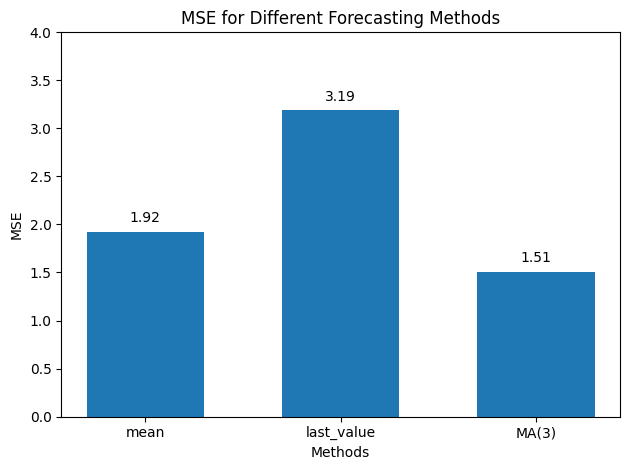

In [33]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(3)']
y = [mse_mean3, mse_last3, mse_MA3]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_title('MSE for Different Forecasting Methods')
ax.set_ylim(0, 4)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()